A notebook to test if subtracting bias helps alleviate the postISR cross-amp differences... The backup copy is in  `results_gaia/dr2_med_full_2020_24_backup` , and the directory where  I update the amp files and run reingest is `results_gaia/dr2_med_full_2020_24` 

* read the raw amp fits files
* subtract the bias value for each amp, update the files 
* remove previously ingested raw files and registry
* reingest raw images
* remove the postISR images
* run postISR on reingested raw images 


(Using `2020_24` stack, on `lsst-aos` kernel )

In [2]:
from lsst.ts.wep.Utility import runProgram
import lsst.daf.persistence as dafPersist
import os
import numpy as np
import matplotlib.pyplot as plt 
import astropy.io.fits as fits

In [3]:
# path to the raw extra-focal repackaged files 
dataDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_gaia/dr2_med_full_2020_24/iter0/img/extra'

       
# remove whatever raw files are there 
argString = '-rf %s/'%dataDir
runProgram("rm", argstring=argString)


Show that it worked:

In [156]:
os.path.exists(dataDir)

False

Copy the raw files from the backup dir: 

In [4]:
backupDir = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_gaia/dr2_med_full_2020_24_backup/iter0/img/extra'
argString = '-a %s/. %s'%(backupDir,dataDir)
runProgram("cp", argstring=argString)


Show that it worked:

In [5]:
os.listdir(dataDir)

['starExtraPhoSim.log',
 'lsst_a_9006001_f1_R22_S00_E000.fits',
 'lsst_a_9006001_f1_R22_S01_E000.fits',
 'lsst_a_9006001_f1_R22_S02_E000.fits',
 'lsst_a_9006001_f1_R22_S10_E000.fits',
 'lsst_a_9006001_f1_R22_S11_E000.fits',
 'lsst_a_9006001_f1_R22_S12_E000.fits',
 'lsst_a_9006001_f1_R22_S20_E000.fits',
 'lsst_a_9006001_f1_R22_S21_E000.fits',
 'lsst_a_9006001_f1_R22_S22_E000.fits',
 'centroid_lsst_e_9006001_f1_R22_S22_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S10_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S11_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S01_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S02_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S00_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S12_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S21_E000.txt',
 'centroid_lsst_e_9006001_f1_R22_S20_E000.txt',
 'ingestImagesHelp.txt']

Subtract bias from each repackaged raw amp image for extra-focal images 

In [6]:
# find the names of the raw amp files 
rawFiles = os.listdir(dataDir)
raw =[]
for x in rawFiles:
    if x.startswith('lsst_a_9006001'):
        raw.append(x)
        
        
# iterate over raw amp files  : print their few initial values      
fname = raw[0]
hdul = fits.open(os.path.join(dataDir, fname))
#for i in range(1,2):
print(hdul[2].data[0][:100]) # for 2nd amp 

[1008 1009 1008 1196 1205 1207 1200 1204 1190 1182 1206 1230 1191 1176
 1195 1217 1211 1204 1208 1212 1194 1206 1202 1212 1206 1190 1193 1213
 1209 1207 1199 1224 1206 1196 1194 1206 1204 1193 1218 1193 1186 1191
 1177 1203 1220 1202 1185 1218 1196 1187 1192 1190 1199 1205 1198 1208
 1200 1191 1185 1201 1185 1187 1202 1207 1216 1204 1185 1220 1190 1194
 1195 1210 1186 1223 1204 1197 1184 1196 1194 1185 1170 1197 1188 1186
 1193 1195 1220 1203 1206 1187 1202 1193 1179 1183 1215 1213 1180 1207
 1201 1193]


In [7]:
hdul = fits.open(os.path.join(dataDir, fname))

In [9]:
i=3


1007.85


In [18]:
# iterate over raw amp files  : update by subtracting bias    
for fname in raw:
    hdul = fits.open(os.path.join(dataDir, fname), mode='update')

    # subtract bias for each amp
    for i in range(1,len(hdul)): # this iterates over 16 amps 
        #chipid = hdul[i].header['ampid']
        bias =  hdul[i].header['Bias']
        gain = hdul[i].header['Gain']
        
        
        data =  hdul[i].data.astype(float)
        data -= bias  # subtract bias
        data *= gain # multiply by gain 
        
        #print(chipid, bias)
        hdul[i].data = data # update the data 
    hdul.flush(verbose=True) # store in place  

Show that the same amp has indeed different data values : 

In [19]:
# iterate over updated amp files  : print their few initial values      
fname = raw[0]
hdul = fits.open(os.path.join(dataDir, fname))
#for i in range(1,2):
print(hdul[2].data[0][:100]) # for 2nd amp 

[  1.03383   2.67483   1.03383 309.54183 324.31083 327.59283 316.10583
 322.66983 299.69583 286.56783 325.95183 365.33583 301.33683 276.72183
 307.90083 344.00283 334.15683 322.66983 329.23383 335.79783 306.25983
 325.95183 319.38783 335.79783 325.95183 299.69583 304.61883 337.43883
 330.87483 327.59283 314.46483 355.48983 325.95183 309.54183 306.25983
 325.95183 322.66983 304.61883 345.64383 304.61883 293.13183 301.33683
 278.36283 321.02883 348.92583 319.38783 291.49083 345.64383 309.54183
 294.77283 302.97783 299.69583 314.46483 324.31083 312.82383 329.23383
 316.10583 301.33683 291.49083 317.74683 291.49083 294.77283 319.38783
 327.59283 342.36183 322.66983 291.49083 348.92583 299.69583 306.25983
 307.90083 332.51583 293.13183 353.84883 322.66983 311.18283 289.84983
 309.54183 306.25983 291.49083 266.87583 311.18283 296.41383 293.13183
 304.61883 307.90083 348.92583 321.02883 325.95183 294.77283 319.38783
 304.61883 281.64483 288.20883 340.72083 337.43883 283.28583 327.59283
 317.7

In [20]:
# Show the old vs new  - there is a difference ... 

rawAmp = {}
for inputDir, dtype  in  zip([backupDir, dataDir], ['old', 'new']):

    fname = 'lsst_a_9006001_f1_R22_S22_E000.fits'

    hdul = fits.open(os.path.join(inputDir, fname))
    rawAmp[dtype] = hdul[1].data


In [21]:
rawAmp['old']  - rawAmp['new']

array([[1002.2592, 1002.2592, 1003.6852, ..., 1000.8332, 1006.5372,
        1002.2592],
       [ 996.5552, 1002.2592, 1006.5372, ..., 1002.9722, 1002.2592,
        1002.9722],
       [1002.9722, 1002.9722, 1005.8242, ..., 1002.2592, 1002.2592,
        1000.1202],
       ...,
       [1002.2592, 1005.8242,  998.6942, ..., 1003.6852, 1001.5462,
        1006.5372],
       [1002.9722, 1000.1202, 1002.9722, ..., 1003.6852, 1008.6762,
        1002.9722],
       [1002.9722, 1007.9632, 1005.8242, ..., 1005.1112, 1005.1112,
        1004.3982]])

the difference is the bias value * gain for that amp - as we would expect ! 

Then, before ingesting  the raw images, need to remove the input/raw/9006001/....  ingested image directory, otherwise new ones won't get ingested 

In [106]:
ingestedDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/\
results_gaia/dr2_med_full_2020_24/input/raw/9006001/'
argString = '-rf %s/'%ingestedDir
runProgram("rm", argstring = argString)

In [107]:
os.path.exists(ingestedDir)

False

We also erase previously existing registry file `input/registry.sqlite3` since this would mess the  ingest process

In [108]:

# also erase previously existing registry since this would mess the 
# ingest process
isrDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/\
results_gaia/dr2_med_full_2020_24/input'
registryFile= os.path.join(isrDir,'registry.sqlite3')
if os.path.exists(registryFile):
    print('Removing image registry file  %s '%registryFile)
    runProgram("rm", argstring=registryFile)


Removing image registry file  /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24/input/registry.sqlite3 


Ensure that the shell used by jupyter has sourced the setup file for `2020_24` ( run in a terminal) : 

In [114]:
argstring = '/epyc/users/suberlak/Commissioning/aos/setup_aos_2020_24.sh'
print("Run in a terminal the following:")
print("source %s"%argstring)


Run in a terminal the following:
source /epyc/users/suberlak/Commissioning/aos/setup_aos_2020_24.sh


Then we can ingest the updated raw extra-focal images : 

In [25]:
# destDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
# analysis_scripts/results_gaia/dr2_med_full_2020_24/input'

destDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_gaia/dr2_med_full_2020_24_ingested/'

if not os.path.exists(destDir):
    os.makedirs(destDir)
    
if not os.path.exists(os.path.join(destDir,'_mapper')):
    mapperPath = '/data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_gaia/dr2_med_full_2020_24_backup/input/_mapper'
    argstring = ' %s %s'%(mapperPath, destDir)
    runProgram("cp", argstring = argstring)
    
rawImgFiles = os.path.join(dataDir, "*_a_*.fits*")
argstring = '%s %s'%(destDir, rawImgFiles)
print("Run in a terminal the following:")
print("ingestImages.py %s"%argstring)

Run in a terminal the following:
ingestImages.py /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_ingested/ /data/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24/iter0/img/extra/*_a_*.fits*


Show that the ingested raw extra-focal images are different than the old ones (before bias subtraction )

In [33]:
rawImages = {}
for add, dtype  in  zip(['_backup/input/','_ingested'], ['old', 'new']):
    repo_dir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24%s'%add

    print('\nReading data from')
    print(repo_dir)
    #print('For sensor %s '%sensor)
    #repo_dir = os.path.join(inputDir, 'input')
    butler = dafPersist.Butler(repo_dir)
    data_id = {'expId': 9006001 , 'filter':'g', 'raftName':'R22',  
               'detectorName': 'S22', 'detector': 98}
    post = butler.get('raw', **data_id) 
    rawImages[dtype] = post.image.array




Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_backup/input/


Ignoring Error calculating property 'boresight_airmass' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['AIRMASS'] in header"
Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['TEMPERA'] in header"
Ignoring Error calculating property 'pressure' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['PRESS'] in header"



Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_ingested


Ignoring Error calculating property 'boresight_airmass' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['AIRMASS'] in header"
Ignoring Error calculating property 'temperature' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['TEMPERA'] in header"
Ignoring Error calculating property 'pressure' using translator <class 'lsst.obs.lsst.translators.phosim.LsstPhoSimTranslator'>: "Could not find ['PRESS'] in header"


In [34]:
rawImages['old']

array([[  2.7408 ,  -7.5372 ,   6.1668 , ...,  -1.48984, -16.72684,
          8.66816],
       [  1.0278 ,   2.7408 ,   1.0278 , ...,   1.89616,   8.66816,
         -3.18284],
       [  7.8798 ,   2.7408 ,   2.7408 , ..., -21.80584, -18.41984,
         -4.87584],
       ...,
       [ -1.76978,  -0.11578, -15.00178, ...,   3.75092,   3.75092,
         -7.30908],
       [ 14.77022, -15.00178,   6.50022, ...,   8.49092,  -0.98908,
          5.33092],
       [ -8.38578,   9.80822, -18.30978, ...,  -5.72908,  -0.98908,
        -13.62908]], dtype=float32)

In [35]:
rawImages['new']

array([[  2.7408 ,  -7.5372 ,   6.1668 , ...,  -1.48984, -16.72684,
          8.66816],
       [  1.0278 ,   2.7408 ,   1.0278 , ...,   1.89616,   8.66816,
         -3.18284],
       [  7.8798 ,   2.7408 ,   2.7408 , ..., -21.80584, -18.41984,
         -4.87584],
       ...,
       [ -1.76978,  -0.11578, -15.00178, ...,   3.75092,   3.75092,
         -7.30908],
       [ 14.77022, -15.00178,   6.50022, ...,   8.49092,  -0.98908,
          5.33092],
       [ -8.38578,   9.80822, -18.30978, ...,  -5.72908,  -0.98908,
        -13.62908]], dtype=float32)

In [36]:
np.where(rawImages['old'] - rawImages['new'] != 0 ) 

(array([], dtype=int64), array([], dtype=int64))

But they aren't ! How could that be given that the updated amp files are definitely different?  

In [147]:
np.sum(np.in1d(rawAmp['old'], rawImages['new']))

1049220

In [146]:
len(np.ravel(rawAmp['old']))

1049220

Once this is addressed : compare the raw pre-ISR images 

/astro/store/epyc/projects/lsst_comm/stack_w_2020_24/conda/miniconda3-4.7.12/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


Text(0.5, 0.98, 'raw dr2_med_full_2020_24 R22_S22')

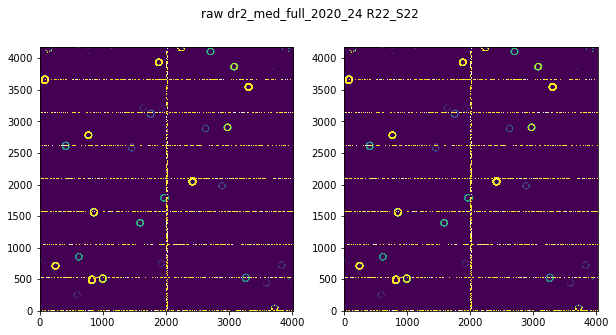

In [90]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(10,5))
import numpy as np 

i = 0 
for label in rawImages.keys(): 
    ax[i].imshow(np.log10(rawImages[label].T), label=label, origin='lower', vmin = 2.45, vmax=2.75)
    i += 1 

fig.suptitle('raw dr2_med_full_2020_24 R22_S22')

Finally we can run the ISR (the config file was not removed, so it already exists... )  

In [116]:
destDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_gaia/dr2_med_full_2020_24/input'
configFile = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/\
analysis_scripts/results_gaia/dr2_med_full_2020_24/input/isr_config.py'
argstring='%s --id --rerun=run1 --configfile %s --no-versions'%(destDir, configFile)

print("Run in a terminal the following:")
print("runIsr.py %s"%argstring)


runIsr.py /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24/input --id --rerun=run1 --configfile /epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24/input/isr_config.py --no-versions


check the results: postISR extra-focal image .... (use `lsst-aos` kernel since it uses `2020_24` butler ...) 

In [124]:
isrImages = {}

for add, dtype  in  zip(['_backup',''], ['old', 'new']):
    inputDir = '/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24%s'%add

    print('\nReading data from')
    print(inputDir)
    
    repo_dir = os.path.join(inputDir, 'input/rerun/run1')
    butler = dafPersist.Butler(repo_dir)
    data_id = {'expId': 9006001 , 'filter':'g', 'raftName':'R22',  
               'detectorName': 'S22', 'detector': 98}
    post = butler.get('postISRCCD', **data_id) 
    isrImages[dtype] = post.image.array


Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24_backup

Reading data from
/epyc/users/suberlak/Commissioning/aos/ts_phosim/notebooks/analysis_scripts/results_gaia/dr2_med_full_2020_24


Text(0.5, 0.98, 'postISR dr2_med_full_2020_24 R22_S22')

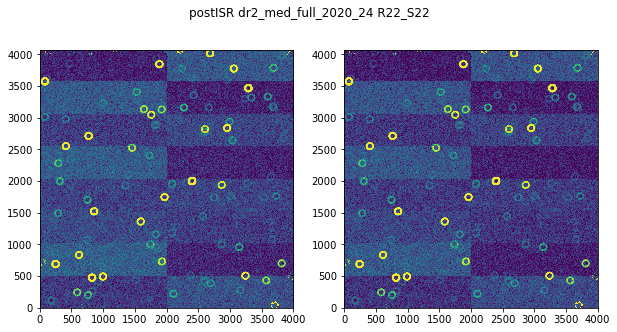

In [125]:
%matplotlib inline
fig,ax = plt.subplots(1,2,figsize=(10,5))
import numpy as np 

i = 0 
for label in isrImages.keys(): 
    image = isrImages[label]
    ax[i].imshow(np.log10(image.T), label=label, origin='lower', vmin = 2.45, vmax=2.75)
    i += 1 

fig.suptitle('postISR dr2_med_full_2020_24 R22_S22')